In [ ]:
# mount the drive
# from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
!pip install pydicom
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.7 MB/s eta 0:00:00


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_core as keras
import keras_cv

import gc
import cv2
import pydicom
from joblib import Parallel, delayed

import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from glob import glob

from tqdm import tqdm
import gc

ModuleNotFoundError: ignored

## Configuration

In [ ]:
class Config:
    IMAGE_SIZE = [256, 256]
    RESIZE_DIM = 256
    BATCH_SIZE = 64
    AUTOTUNE = tf.data.AUTOTUNE
    TARGET_COLS  = ["bowel_healthy", "bowel_injury", "extravasation_healthy",
                   "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

config = Config()

In [ ]:
BASE_PATH = '/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset'


In [ ]:
meta_df = pd.read_csv(f"{BASE_PATH}/test_series_meta.csv")

# Checking if patients are repeated by finding the number of unique patient IDs
num_rows = meta_df.shape[0]
unique_patients = meta_df["patient_id"].nunique()

print(f"{num_rows=}")
print(f"{unique_patients=}")
num_rows=6
unique_patients=3

num_rows=6
unique_patients=3


In [ ]:
from glob import glob

test_data = sorted(glob('/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/test_images/*/*/*.png'))
print(len(test_data))

3


In [ ]:
test_df = pd.read_csv(f"{BASE_PATH}/test.csv")

test_df["image_path"] = f"{BASE_PATH}/test_images"\
                    + "/" + test_df.patient_id.astype(str)\
                    + "/" + test_df.series_id.astype(str)\
                    + "/" + test_df.instance_number.astype(str) +".png"

test_df.head(2)

,image_path,patient_id,series_id,instance_number,width,height
0,/content/drive/MyDrive/test/rsna-atd-512x512-p...,63706,39279,30,512,512
1,/content/drive/MyDrive/test/rsna-atd-512x512-p...,50046,24574,30,512,512


In [ ]:
# Checking if patients are repeated by finding the number of unique patient IDs
num_rows = test_df.shape[0]
unique_patients = test_df["patient_id"].nunique()

print(f"{num_rows=}")
print(f"{unique_patients=}")
num_rows=3
unique_patients=3

num_rows=3
unique_patients=3


In [ ]:
# !rm -r {IMAGE_DIR}
# os.makedirs(f"{IMAGE_DIR}/train_images", exist_ok=True)
# os.makedirs(f"{IMAGE_DIR}/test_images", exist_ok=True)

In [ ]:
# %%time

# file_paths = test_df.dicom_path.tolist()
# _ = Parallel(n_jobs=2, backend="threading")(
#     delayed(resize_and_save)(file_path) for file_path in tqdm(file_paths, leave=True, position=0)
# )

# del _; gc.collect()

In [ ]:
def decode_image(image_path):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    return image

def build_dataset(image_paths):
    ds = (
        tf.data.Dataset.from_tensor_slices(image_paths)
        .map(decode_image, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [ ]:
paths  = test_df.image_path.tolist()

ds = build_dataset(image_paths=paths)
images = next(iter(ds))

images.shape

TensorShape([3, 256, 256, 3])

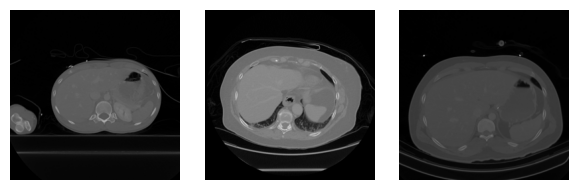

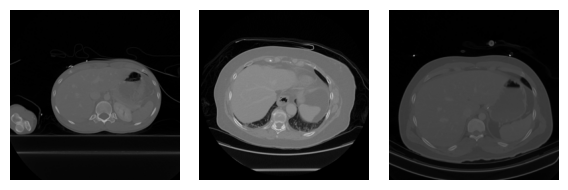

In [ ]:
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=1,
    cols=3,
)

In [ ]:
def post_proc(pred):
    proc_pred = np.empty((pred.shape[0], 2*2 + 3*3), dtype="float32")

    # bowel, extravasation
    proc_pred[:, 0] = pred[:, 0]
    proc_pred[:, 1] = 1 - pred[:, 0]
    proc_pred[:, 2] = pred[:, 1]
    proc_pred[:, 3] = 1 - pred[:, 2]

    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:, 2:5]
    proc_pred[:, 7:10] = pred[:, 5:8]
    proc_pred[:, 10:13] = pred[:, 8:11]

    return proc_pred

In [ ]:
# model = tf.keras.models.load_model("모델경로")
# # Show the model architecture
# model.summary()

In [ ]:
# Getting unique patient IDs from test dataset
patient_ids = test_df["patient_id"].unique()

# Initializing array to store predictions
patient_preds = np.zeros(
    shape=(len(patient_ids), 2*2 + 3*3),
    dtype="float32"
)

# Iterating over each patient
for pidx, patient_id in tqdm(enumerate(patient_ids), total=len(patient_ids), desc="Patients "):
    print(f"Patient ID: {patient_id}")

    # Query the dataframe for a particular patient
    patient_df = test_df[test_df["patient_id"] == patient_id]

    # Getting image paths for a patient
    patient_paths = patient_df.image_path.tolist()

    # Building dataset for prediction
    dtest = build_dataset(patient_paths)

    # Predicting with the model
    pred = model.predict(dtest)
    pred = np.concatenate(pred, axis=-1).astype("float32")
    pred = pred[:len(patient_paths), :]
    pred = np.mean(pred.reshape(1, len(patient_paths), 11), axis=0)
    pred = np.max(pred, axis=0, keepdims=True)

    patient_preds[pidx, :] += post_proc(pred)[0]


    # Deleting variables to free up memory
    del patient_df, patient_paths, dtest, pred; gc.collect()

NameError: ignored

In [ ]:
# Create Submission
pred_df = pd.DataFrame({"patient_id":patient_ids,})
pred_df[config_infer.TARGET_COLS] = patient_preds.astype("float32")

# Align with sample submission
sub_df = pd.read_csv(f"{BASE_PATH}/sample_submission.csv")
sub_df = sub_df[["patient_id"]]
sub_df = sub_df.merge(pred_df, on="patient_id", how="left")

# Store submission
sub_df.to_csv(BASE_PATH + "/제목 수정 ",index=False)
sub_df.head(2)